In [1]:
# This notebook performs EOS inference on simulated BNS observations, 
# to show that running lwp via condor reproduces the same result

%matplotlib inline

In [2]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import os
import bilby.gw.conversion as conversion
import matplotlib.pyplot as plt
import copy
from  scipy.special import logsumexp, rel_entr
from scipy.stats import multivariate_normal
import seaborn as sns
import h5py

import sys
sys.path.insert(0,'/home/philippe.landry/lwp')
import lwp
import lwp.executables.get_files as get_files

from lwp import executables

In [3]:
# load the EOSs to use in inference in the required format,
# i.e. a dict mapping an integer EOS number to a tabulated m-Lambda relation

eos_samples_file =  "/home/philippe.landry/lwp_compare/eos/LCEHL_EOS_posterior_samples_PSR.h5"
eos_samples_tag = "ns"
eos_id_tag = "eos"
samples  = h5py.File(eos_samples_file)
ex_ns = np.array(samples[eos_samples_tag]['eos_0'])

#eos_to_be_used = np.array(samples['id']) # use all available EOSs
eos_to_be_used=np.arange(100) # or instead just use this many
macro_data = {eos_num: np.array(samples[eos_samples_tag][eos_id]) for eos_num, eos_id in enumerate(samples[eos_id_tag])}

In [4]:
# specify the GW likelihoods to analyze with lwp_pipe

events = ["BNS0apr4TF2_5k","BNS1apr4TF2_5k","BNS2apr4TF2_5k"]

for event in events:

    astro_prefix= event

    astro_data_and_metadata = executables.get_files.get_astro_samples(
        '../obs/'+astro_prefix+'.csv', # load existing astro samples
        '../obs/'+astro_prefix+'.csv', # re-save astro samples, but should be identical as they're already formatted correctly for lwp
        download_url=None,
        max_num_pe_samples=None,
        load_samples_kwargs={},
        scan_likelihood=False # don't re-scan likelihood, there's already a bandwidth file for the samples
    )

    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    print('optimal bw: '+str(bandwidth))
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])
    mass_ratio_range = np.array(astro_data_and_metadata["q_range"].iloc[0,:])
    
    # set up the lwp EOS inference
    # first, dump the config ("ini") file needed to run lwp-pipe bin script;
    # just call `bin/lwp-pipe config.ini` and the call will execute

    result = executables.lwp_pipe(eos_indices = np.array(eos_to_be_used),
                    retrieve_macro_data = lambda index: macro_data[index],
                    gw_posterior_samples = astro_data,
                    likelihood_bandwidth=bandwidth, 
                    likelihood_prior_key='flat_m1m2',
                    prior_columns = ['m1','m2'],
                    save_likelihoods=f"./{astro_prefix}_post.csv",
                    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv",
                    mc_marginalization_range=chirp_mass_range,
                    q_marginalization_range=mass_ratio_range,
                    num_marginalization_points=1000,
                    seed=12345,
                    dump_config=astro_prefix+"_compare.ini", 
                    dump_config_kwargs={"config_kwargs": {"eos-indices": "./BNSapr4_compare/eos_indices.csv"}, 
                                        "lwp_pipe_data_kwargs":{"gw_posterior_samples": '/home/philippe.landry/lwp_compare/obs/'+astro_prefix+".csv",
                                                                "eos_samples_h5_path": eos_samples_file, 
                                                                "eos_samples_h5_macro_subgroup": eos_samples_tag,
                                                                "eos_samples_h5_index_subgroup": eos_id_tag,
                                                                "outdir":"./BNSapr4_compare/"}})
    
    # run the lwp EOS inference
    # rather than executing with the shell, just copy the inputs and run the analysis in this notebook
    
    result = executables.lwp_pipe(eos_indices = np.array(eos_to_be_used),
                    retrieve_macro_data = lambda index: macro_data[index],
                    gw_posterior_samples = astro_data,
                    likelihood_bandwidth=bandwidth, 
                    likelihood_prior_key='flat_m1m2',
                    prior_columns = ['m1','m2'],
                    save_likelihoods=f"./BNSapr4_compare/{astro_prefix}_post.csv",
                    save_marginalized_likelihoods=f"./BNSapr4_compare/{astro_prefix}_eos.csv",
                    mc_marginalization_range=chirp_mass_range,
                    q_marginalization_range=mass_ratio_range,
                    num_marginalization_points=1000,
                    seed=12345)

successfully got 1551 pe samples,
optimal bw: 0.1422006854868455
successfully got 1738 pe samples,
optimal bw: 0.1309330807022389
successfully got 2781 pe samples,
optimal bw: 0.1460745418782322


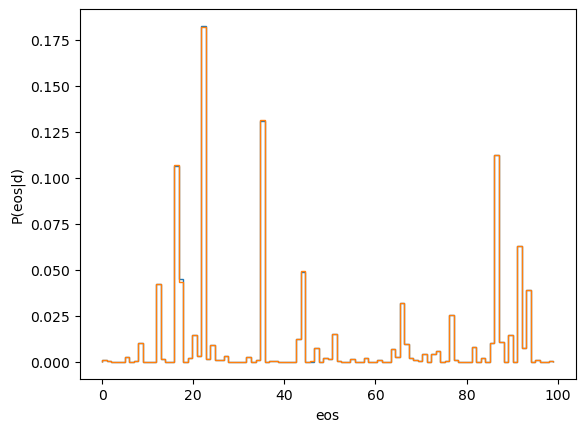

In [5]:
# load the computed EOS likelihoods
# plot the posteriors from this notebook's analysis vs those from the condor analysis

eos_likes = {}

for event in events: # notebook analysis
    
    eos_likes[event] = np.genfromtxt('./BNSapr4_compare/'+event+'_eos.csv',names=True,dtype=None,encoding=None,delimiter=',')

eos_keys = eos_likes[events[0]]['eos']
eos_wts = eos_likes[events[0]]['logmargweight'] + eos_likes[events[1]]['logmargweight'] + eos_likes[events[2]]['logmargweight']

plt.hist(eos_keys,bins=100,density=True,weights=eos_wts/np.sum(eos_wts),histtype='step')

eos_likes_compare = {}

for event_num,event in enumerate(events): # condor analysis
    
    eos_likes_compare[event] = np.genfromtxt('./bns{0}apr4/result/bns{0}apr4_eos.csv'.format(event_num),names=True,dtype=None,encoding=None,delimiter=',')

eos_keys_compare = eos_likes_compare[events[0]]['eos'][:eos_to_be_used[-1]+1]
eos_wts_compare = eos_likes_compare[events[0]]['logmargweight'][:eos_to_be_used[-1]+1] + eos_likes[events[1]]['logmargweight'][:eos_to_be_used[-1]+1] + eos_likes[events[2]]['logmargweight'][:eos_to_be_used[-1]+1]

plt.hist(eos_keys_compare,bins=100,density=True,weights=eos_wts_compare/np.sum(eos_wts_compare),histtype='step')

plt.xlabel('eos')
plt.ylabel('P(eos|d)')
plt.show()